In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image

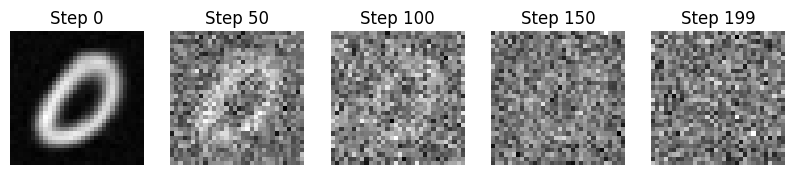

In [ ]:

T = 200  
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)  

alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)  

def add_noise(image, t):
    """Adds Gaussian noise to an image at time step t."""
    sqrt_alpha_t = torch.sqrt(alphas_cumprod[t])
    sqrt_one_minus_alpha_t = torch.sqrt(1 - alphas_cumprod[t])
    noise = torch.randn_like(image)
    return sqrt_alpha_t * image + sqrt_one_minus_alpha_t * noise, noise

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

DATASET_PATH = "/srv/shareddata/datasets/course101/minst-data-vae"  # Change this path to your local MNIST dataset

dataset = datasets.DatasetFolder(root=DATASET_PATH, loader=lambda x: Image.open(x).convert("L"), extensions=('png', 'jpg', 'jpeg'), transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

fig, axes = plt.subplots(1, 5, figsize=(10, 5))
time_steps = [0, 50, 100, 150, 199]

for i, t in enumerate(time_steps):
    noisy_image, _ = add_noise(dataset[0][0], t)
    axes[i].imshow(noisy_image.squeeze(), cmap="gray")
    axes[i].set_title(f"Step {t}")
    axes[i].axis("off")

plt.show()


In [61]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

        self.middle = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

unet = SimpleUNet()


In [62]:
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

num_epochs = 5
device = "cuda" if torch.cuda.is_available() else "cpu"
unet.to(device)

for epoch in range(num_epochs):
    for images, _ in tqdm(dataloader):
        images = images[0].to(device)  # Fix unpacking issue
        t = torch.randint(0, T, (images.shape[0],), device=device)
        noisy_images, noise = add_noise(images, t)
        predicted_noise = unet(noisy_images)
        loss = loss_fn(predicted_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")



100%|██████████| 2/2 [00:00<00:00, 34.81it/s]


Epoch 1, Loss: 1.0873


100%|██████████| 2/2 [00:00<00:00, 39.91it/s]


Epoch 2, Loss: 0.9400


100%|██████████| 2/2 [00:00<00:00, 40.10it/s]


Epoch 3, Loss: 1.0307


100%|██████████| 2/2 [00:00<00:00, 40.08it/s]


Epoch 4, Loss: 0.9706


100%|██████████| 2/2 [00:00<00:00, 39.85it/s]

Epoch 5, Loss: 0.8263


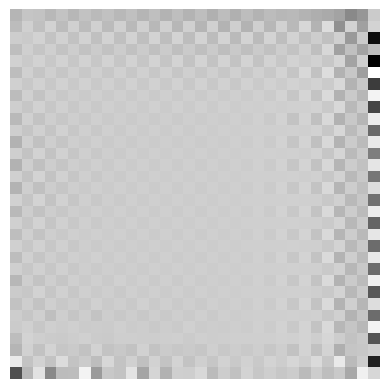

In [63]:
@torch.no_grad()
def generate_image():
    x = torch.randn((1, 1, 32, 32), device=device)  # Start with random noise
    for t in reversed(range(T)):
        noise_pred = unet(x)
        alpha_t = torch.sqrt(alphas_cumprod[t])
        beta_t = torch.sqrt(1 - alphas_cumprod[t])
        if t > 0:
            z = torch.randn_like(x)
            x = (1 / alpha_t) * (x - beta_t * noise_pred) + torch.sqrt(betas[t]) * z
        else:
            x = (1 / alpha_t) * (x - beta_t * noise_pred)
    return x

generated_image = generate_image().cpu().squeeze()
plt.imshow(generated_image, cmap="gray")
plt.axis("off")
plt.show()
